In [1]:
#Import required libraries and packages

import numpy as np
import pandas as pd
import seaborn as sns
from pandas_datareader import data
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

#Load data on covid cases and state population attributes
kff_data=pd.read_csv('kff_raw_data.csv',index_col=0)
insurance=kff_data[8:9].T
insurance.index=kff_data.iloc[1]
insurance.index.names = ['State']

#Perform some cleaning and preprocessing on uninsured data
insurance.columns = insurance.columns.str.replace(' ', '_')
insurance['Uninsured']=insurance['Uninsured'].str.rstrip('%').astype('float') / 100.0

#Find mortality and infections rates
cases=kff_data[36:41].T
cases.index=kff_data.iloc[1]
cases.index.names = ['State']
cases.columns = cases.columns.str.replace(' ', '_')
cases["Number_of_COVID-19_Cases"]=cases["Number_of_COVID-19_Cases"].str.replace(',', '').astype(int)
cases["COVID-19_Cases_per_1,000,000_Population"]=cases["COVID-19_Cases_per_1,000,000_Population"].str.replace(',', '').astype(int)
cases["Deaths_from_COVID-19"]=cases["Deaths_from_COVID-19"].str.replace(',', '').astype(int)
cases["COVID-19_Deaths_per_1,000,000_Population"]=cases["COVID-19_Deaths_per_1,000,000_Population"].str.replace(',', '').astype(int)
cases['COVID-19_Fatality_Rate']=cases['COVID-19_Fatality_Rate'].str.rstrip('%').astype('float') / 100.0

#Load covid tracker on 14 day percent change on cases
covid_tracking=pd.read_csv('covid_tracking.csv')
covid_tracking.drop(['Unnamed: 0'], axis=1, inplace=True)
covid_tracking.drop([31], inplace=True)
covid_tracking.set_index('State',inplace=True)
covid_tracking.columns = covid_tracking.columns.str.replace(' ', '_')

#Perform some cleanup and preprocessing
waivers=kff_data[93:99].T
waivers.index=kff_data.iloc[1]
waivers.index.names = ['State']
waivers.columns = waivers.columns.str.replace(' ', '_')

waivers2=kff_data[101:102].T
waivers2.index=kff_data.iloc[1]
waivers2.index.names = ['State']
waivers2.columns = waivers2.columns.str.replace(' ', '_')


#Find proportion of elderly in each state
elderly=kff_data[109:111].T
elderly.index=kff_data.iloc[1]
elderly.index.names = ['State']
elderly.rename(columns={'Total number, adults age 65 and older': 'Total number of at risk adults, age 65 and older'},inplace=True)
elderly.columns = elderly.columns.str.replace(' ', '_')
elderly["Total_number_of_at_risk_adults,_age_65_and_older"]=elderly["Total_number_of_at_risk_adults,_age_65_and_older"].str.replace(',', '').astype('float')
elderly['Older_adults,_as_a_share_of_all_at-risk_adults']=elderly['Older_adults,_as_a_share_of_all_at-risk_adults'].str.rstrip('%').astype('float') / 100.0


#Find numbers of population who do not seek medical help due to costs
cost_df=kff_data[112:113].T
cost_df.index=kff_data.iloc[1]
cost_df.index.names = ['State']
cost_df.rename(columns={'All Adults': 'Adults Reporting Not Seeing a Doctor in the Past 12 Months Because of Cost'},inplace=True)
cost_df.columns = cost_df.columns.str.replace(' ', '_')
cost_df['Adults_Reporting_Not_Seeing_a_Doctor_in_the_Past_12_Months_Because_of_Cost']=cost_df['Adults_Reporting_Not_Seeing_a_Doctor_in_the_Past_12_Months_Because_of_Cost'].str.rstrip('%').astype('float') / 100.0


#Find proportion of senios living with school kids
seniors_kids=pd.read_csv('seniors_kids.csv')
seniors_kids.drop(['Unnamed: 0'], axis=1, inplace=True)
seniors_kids.drop([52,53], inplace=True)
seniors_kids.set_index('State',inplace=True)
seniors_kids.rename(index={'U.S. Total':'United States'},inplace=True)
seniors_kids[["Number of Seniors Livings with School-Age Kids", "Number of Seniors","Number of School-Age Kids Living with Seniors","Number of School-Age Kids"]] = seniors_kids[["Number of Seniors Livings with School-Age Kids", "Number of Seniors","Number of School-Age Kids Living with Seniors","Number of School-Age Kids"]].apply(pd.to_numeric)
seniors_kids['Share of Seniors living With School-Age Kids']=seniors_kids['Share of Seniors living With School-Age Kids'].str.rstrip('%').astype('float') / 100.0
seniors_kids['Share of School-Age Kids Living with Seniors']=seniors_kids['Share of School-Age Kids Living with Seniors'].str.rstrip('%').astype('float') / 100.0
seniors_kids.columns = seniors_kids.columns.str.replace(' ', '_')

#Load state location longitude and latitude, provinces
US_input_report=pd.read_csv('project2_input_US.csv')
US_input_report.index=US_input_report['Province_State']
US_input_report.index.names = ['State']
US_input_report.drop(['Province_State'],axis=1,inplace=True)

#Find population per State
population=pd.DataFrame(data=US_input_report['Population'],index=US_input_report.index)
population=population.groupby('State').sum()

#Load data set on transmission rate
transmission_rate=pd.read_csv('rt.csv')
transmission_rate.rename(columns={'region': 'State_Code','mean':'Transmission_Rate_Per_Human'},inplace=True)
transmission_rate=transmission_rate[transmission_rate['date']=="2020-07-18"]

#Load state codes table to interprete state names
state_codes=pd.read_csv('statecodes.csv')
state_codes.rename(columns={'Code': 'State_Code'},inplace=True)
transmissions_state = pd.merge(state_codes,transmission_rate)
transmissions_state=pd.DataFrame(data=transmissions_state[['Transmission_Rate_Per_Human','State']])
transmissions_state.set_index('State',inplace=True)

In [2]:
# Consolidate all key information to be studied on covid into one dataframe

consolidated_cd = pd.concat([cases,seniors_kids,insurance,waivers,waivers2,elderly,cost_df,population,transmissions_state], axis=1,join="inner")

#Drop blank rows
consolidated_cd = consolidated_cd.dropna(how='any',axis=0)

#Find percentage of seniors in each state
consolidated_cd['Senior_Rate']=consolidated_cd['Number_of_Seniors']/consolidated_cd['Population']

#Create dataframe to study relationship between Covid and number of seniors in each state
seniors_df=pd.DataFrame(data=consolidated_cd[['COVID-19_Fatality_Rate','Transmission_Rate_Per_Human','Senior_Rate','Share_of_Seniors_living_With_School-Age_Kids']],index=consolidated_cd.index)

#Create dataframe to study relationship between Covid and number of uninsured people in each state
non_insured=pd.DataFrame(data=consolidated_cd[['COVID-19_Fatality_Rate','Transmission_Rate_Per_Human','Senior_Rate','Adults_Reporting_Not_Seeing_a_Doctor_in_the_Past_12_Months_Because_of_Cost','Uninsured']],index=consolidated_cd.index)


In [3]:
#Sort states by Mortality rate showing percentage of seniors in those states
seniors_df.sort_values(by=['COVID-19_Fatality_Rate'], inplace=True, ascending=False)

#View data
seniors_df

,COVID-19_Fatality_Rate,Transmission_Rate_Per_Human,Senior_Rate,Share_of_Seniors_living_With_School-Age_Kids
State,,,,
New Jersey,0.09,1.007278,0.157957,0.07
Connecticut,0.09,0.995959,0.165765,0.05
New York,0.08,0.967643,0.119029,0.07
Michigan,0.08,0.971840,0.167821,0.04
Massachusetts,0.07,1.069877,0.160029,0.06
Pennsylvania,0.07,1.032362,0.175832,0.04
New Hampshire,0.06,1.052768,0.174302,0.04
Rhode Island,0.06,1.127522,0.165194,0.05
Indiana,0.05,1.033469,0.150768,0.04


In [4]:
#Check shape of non-insured table
non_insured.shape

(50, 5)

In [5]:
#Sort states by Mortality rate showing proportion uninsured
non_insured.sort_values(by=['COVID-19_Fatality_Rate'], inplace=True, ascending=False)
non_insured

,COVID-19_Fatality_Rate,Transmission_Rate_Per_Human,Senior_Rate,Adults_Reporting_Not_Seeing_a_Doctor_in_the_Past_12_Months_Because_of_Cost,Uninsured
State,,,,,
New Jersey,0.09,1.007278,0.157957,0.131,0.07
Connecticut,0.09,0.995959,0.165765,0.092,0.05
New York,0.08,0.967643,0.119029,0.110,0.05
Michigan,0.08,0.971840,0.167821,0.118,0.05
Massachusetts,0.07,1.069877,0.160029,0.088,0.03
Pennsylvania,0.07,1.032362,0.175832,0.094,0.06
New Hampshire,0.06,1.052768,0.174302,0.106,0.05
Rhode Island,0.06,1.127522,0.165194,0.105,0.04
Indiana,0.05,1.033469,0.150768,0.122,0.08


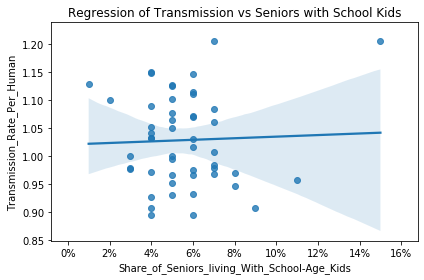

In [6]:
import matplotlib.ticker as mtick

#Plot seaborn regression plot of Proportion of Seniors versus Transmission rate per State

ax1=sns.regplot('Share_of_Seniors_living_With_School-Age_Kids','Transmission_Rate_Per_Human',data=seniors_df)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
ax1.set_title('Regression of Transmission vs Seniors with School Kids')
plt.tight_layout()

plt.show()


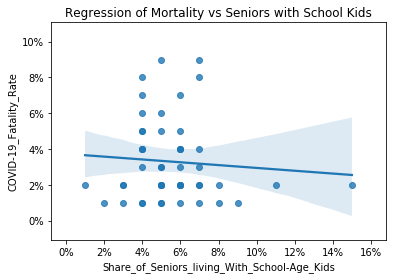

In [7]:
import matplotlib.ticker as mtick

#Plot seaborn regression plot of Proportion of Seniors living with School Kids versus Mortality Rate

ax1=sns.regplot('Share_of_Seniors_living_With_School-Age_Kids','COVID-19_Fatality_Rate',data=seniors_df)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
ax1.set_title('Regression of Mortality vs Seniors with School Kids')
plt.show()
#ax1.set(xlim=(0, 500000))
#ax1.set(ylim=(0, 500000))

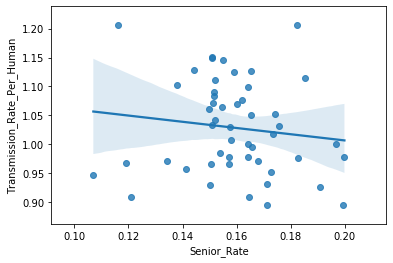

In [8]:
#Plot Proportion of Seniors vs Transmission rate

ax1=sns.regplot('Senior_Rate','Transmission_Rate_Per_Human',data=seniors_df)


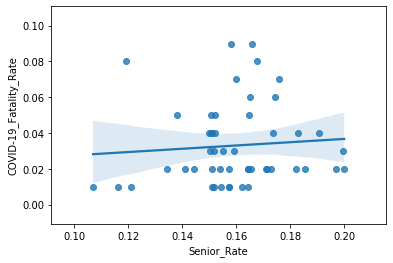

In [9]:
#Plot proportion of Seniors in each State versus Mortality Rate

ax1=sns.regplot('Senior_Rate','COVID-19_Fatality_Rate',data=seniors_df)


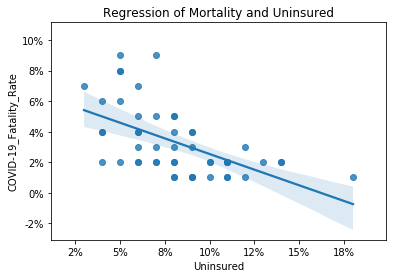

In [10]:
import matplotlib.ticker as mtick

#Plot regression of mortality rate and uninsured rate

ax1=sns.regplot('Uninsured','COVID-19_Fatality_Rate',data=non_insured)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
ax1.set_title('Regression of Mortality and Uninsured')
plt.show()


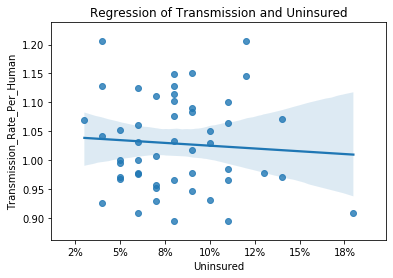

In [11]:
import matplotlib.ticker as mtick

#Plot Regression of Infection rate and Uninsured Rate

ax1=sns.regplot('Uninsured','Transmission_Rate_Per_Human',data=non_insured)
ax1.set_title('Regression of Transmission and Uninsured')
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1))
plt.show()


(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text xticklabel objects>)

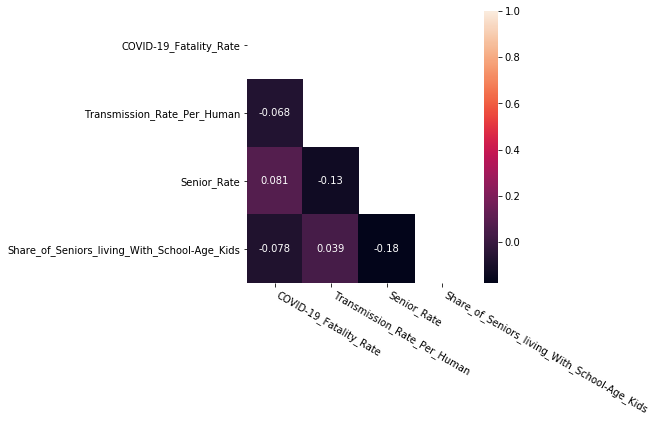

In [12]:

#Plot Correlation heatmap of Seniors, living with school children, fatality rate and infection rate

C=seniors_df.corr()
fig, ax = plt.subplots(figsize=(5,5)) 
mask=np.ones_like(C,dtype=np.bool)
mask=np.triu(mask)  
sns.heatmap(C,annot=True,mask=mask,cbar=True)
plt.xticks(rotation=-30) 
plt.xticks(ha='left')

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text xticklabel objects>)

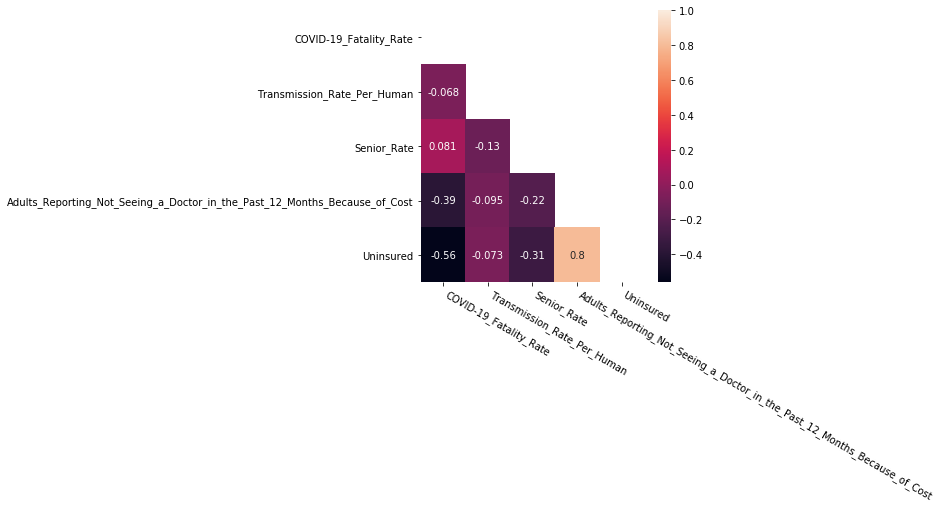

In [13]:
#Plot Correlation heatmap of Uninsured, People not seeking medical assistance due to cost, Transmission Rate and Mortality 

D=non_insured.corr()
fig, ax = plt.subplots(figsize=(5,5)) 
mask=np.ones_like(D,dtype=np.bool)
mask=np.triu(mask)  
sns.heatmap(D,annot=True,mask=mask,cbar=True)
plt.xticks(rotation=-30) 
plt.xticks(ha='left')